     pcost       dcost       gap    pres   dres
 0: -3.7502e+00 -6.5846e+00  9e+01  9e+00  2e+00
 1: -4.7651e+00 -1.8274e+00  1e+01  1e+00  3e-01
 2: -2.2735e-01 -5.0465e-01  5e-01  2e-02  4e-03
 3: -2.9632e-01 -3.5204e-01  8e-02  3e-03  5e-04
 4: -3.3663e-01 -3.4610e-01  1e-02  2e-04  4e-05
 5: -3.4433e-01 -3.4450e-01  2e-04  3e-06  7e-07
 6: -3.4447e-01 -3.4448e-01  2e-06  3e-08  7e-09
 7: -3.4448e-01 -3.4448e-01  2e-08  3e-10  7e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.7031e+00 -5.9199e+01  3e+02  2e+00  2e-15
 1: -2.1090e+00 -2.5838e+01  4e+01  2e-01  2e-15
 2: -5.1932e-01 -4.0258e+00  5e+00  3e-02  2e-15
 3: -1.7279e-01 -5.3501e-01  4e-01  2e-16  1e-15
 4: -2.8306e-01 -3.7752e-01  9e-02  2e-16  6e-16
 5: -3.3602e-01 -3.5289e-01  2e-02  2e-16  6e-16
 6: -3.4426e-01 -3.4467e-01  4e-04  2e-16  7e-16
 7: -3.4447e-01 -3.4448e-01  4e-06  2e-16  5e-16
 8: -3.4448e-01 -3.4448e-01  4e-08  1e-16  6e-16
Optimal solution found.
🔹 Hard Margin Predictio

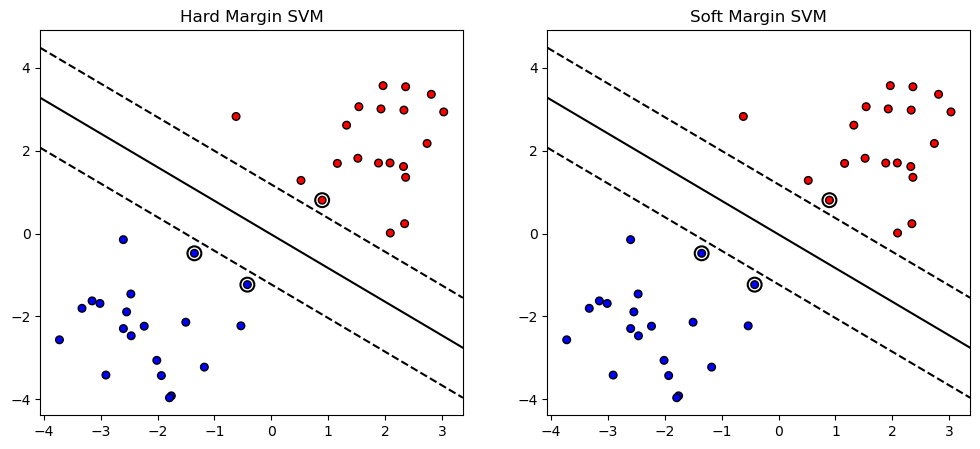

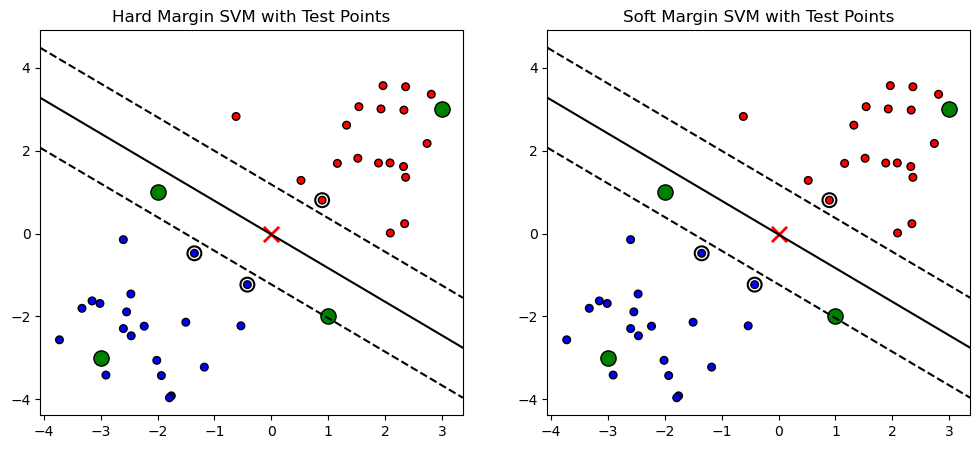

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

# ---------- Step 1: Create dataset ----------
np.random.seed(42)
X1 = np.random.randn(20, 2) - [2, 2]   # Class -1
X2 = np.random.randn(20, 2) + [2, 2]   # Class +1
X = np.vstack((X1, X2))
y = np.hstack((-1*np.ones(20), np.ones(20)))

n_samples, n_features = X.shape

# ---------- Step 2: SVM training function ----------
def svm_train(X, y, C=None):
    # Gram matrix
    K = np.dot(X, X.T) * np.outer(y, y)

    # Quadratic programming matrices
    P = matrix(K, tc='d')
    q = matrix(-np.ones(n_samples), tc='d')

    G_std = np.diag(np.ones(n_samples) * -1)
    h_std = np.zeros(n_samples)

    if C is None:  # Hard margin
        G = matrix(G_std, tc='d')
        h = matrix(h_std, tc='d')
    else:          # Soft margin
        G = matrix(np.vstack((G_std, np.identity(n_samples))), tc='d')
        h = matrix(np.hstack((h_std, np.ones(n_samples) * C)), tc='d')

    A = matrix(y.reshape(1, -1), tc='d')
    b = matrix(np.zeros(1), tc='d')

    # Solve QP problem
    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x']).flatten()

    # Support vectors
    sv = (alphas > 1e-5)
    w = np.dot((alphas * y), X)
    b = np.mean(y[sv] - np.dot(X[sv], w))

    return w, b, sv

# ---------- Step 3: Train both models ----------
w_hard, b_hard, sv_hard = svm_train(X, y, C=None)
w_soft, b_soft, sv_soft = svm_train(X, y, C=1.0)

# ---------- Step 4: Prediction function ----------
def predict(X, w, b):
    return np.sign(np.dot(X, w) + b)

# ---------- Step 6: Misclassification check ----------
def evaluate(X, y, w, b, name="Model"):
    y_pred = predict(X, w, b)
    misclassified = np.sum(y_pred != y)
    accuracy = np.mean(y_pred == y) * 100
    print(f"\n{name} Evaluation:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Misclassified points: {misclassified} / {len(y)}")
    return misclassified


# Sample test dataset
X_test = np.array([[0, 0], [-3, -3], [3, 3], [1, -2], [-2, 1]])
y_pred_hard = predict(X_test, w_hard, b_hard)
y_pred_soft = predict(X_test, w_soft, b_soft)

print("🔹 Hard Margin Predictions:")
for pt, pred in zip(X_test, y_pred_hard):
    print(f"Point {pt} -> Class {int(pred)}")

print("\n🔹 Soft Margin Predictions:")
for pt, pred in zip(X_test, y_pred_soft):
    print(f"Point {pt} -> Class {int(pred)}")

print("\nNumber of support vectors:")
print(f"Hard Margin: {np.sum(sv_hard)}")
print(f"Soft Margin: {np.sum(sv_soft)}")

# ---------- Step 5: Plot results ----------
def plot_svm(X, y, w, b, sv, title, subplot):
    plt.subplot(1, 2, subplot)
    plt.title(title)

    # Plot data points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.bwr, s=30, edgecolors='k')
    plt.scatter(X[sv][:, 0], X[sv][:, 1], s=100,
                facecolors='none', edgecolors='k', linewidths=1.5)

    ax = plt.gca()
    xlim = ax.get_xlim()
    xx = np.linspace(xlim[0], xlim[1], 50)
    yy = -(w[0] * xx + b) / w[1]
    margin = 1 / np.linalg.norm(w)

    plt.plot(xx, yy, 'k-')
    plt.plot(xx, yy + margin, 'k--')
    plt.plot(xx, yy - margin, 'k--')

    plt.xlim(xlim)
    plt.ylim(ax.get_ylim())

def plot_with_test(X, y, w, b, sv, X_test, y_test, title, subplot):
    plt.subplot(1, 2, subplot)
    plt.title(title)

    # Training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.bwr, s=30, edgecolors='k')
    plt.scatter(X[sv][:, 0], X[sv][:, 1], s=100,
                facecolors='none', edgecolors='k', linewidths=1.5)

    # Decision boundary
    ax = plt.gca()
    xlim = ax.get_xlim()
    xx = np.linspace(xlim[0], xlim[1], 50)
    yy = -(w[0] * xx + b) / w[1]
    margin = 1 / np.linalg.norm(w)

    plt.plot(xx, yy, 'k-')
    plt.plot(xx, yy + margin, 'k--')
    plt.plot(xx, yy - margin, 'k--')

    # Test points
    y_pred = predict(X_test, w, b)
    correct = (y_pred == y_test)
    for pt, pred, true in zip(X_test, y_pred, y_test):
        if pred == true:
            plt.scatter(pt[0], pt[1], c='g', marker='o', s=120, edgecolors='k', label="Correct")
        else:
            plt.scatter(pt[0], pt[1], c='r', marker='x', s=120, linewidths=2, label="Misclassified")

    plt.xlim(xlim)
    plt.ylim(ax.get_ylim())


# Evaluate on training data
evaluate(X, y, w_hard, b_hard, "Hard Margin SVM")
evaluate(X, y, w_soft, b_soft, "Soft Margin SVM")

# Evaluate on test data
y_test = np.array([-1, -1, 1, -1, -1])  # true labels of X_test
evaluate(X_test, y_test, w_hard, b_hard, "Hard Margin SVM (Test)")
evaluate(X_test, y_test, w_soft, b_soft, "Soft Margin SVM (Test)")


plt.figure(figsize=(12, 5))
plot_svm(X, y, w_hard, b_hard, sv_hard, "Hard Margin SVM", 1)
plot_svm(X, y, w_soft, b_soft, sv_soft, "Soft Margin SVM", 2)
plt.show()

plt.figure(figsize=(12, 5))
plot_with_test(X, y, w_hard, b_hard, sv_hard, X_test, y_test, "Hard Margin SVM with Test Points", 1)
plot_with_test(X, y, w_soft, b_soft, sv_soft, X_test, y_test, "Soft Margin SVM with Test Points", 2)
plt.show()
